In [1]:
# Imports
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure 
from math import cos, asin, sqrt
from shapely.geometry import Point
from sklearn.preprocessing import MinMaxScaler

## 1. Cleanup

A sample dataset of request logs is given in data/DataSample.csv. We consider records that have identical geoinfo and timest as suspicious and remove those records.

In [2]:
# Read csv's into a Pandas Dataframe
data = pd.read_csv('data/DataSample.csv')
poi = pd.read_csv('data/POIList.csv')

In [3]:
# Drop data records having identical geoInfo and timestamps
drop_list = [' TimeSt', 'Latitude', 'Longitude']
for record in drop_list:
    data= data.drop_duplicates(subset=record)

# Preview resulting data dataframe
data

,_ID,TimeSt,Country,Province,City,Latitude,Longitude
0,4516516,2017-06-21 00:00:00.143,CA,ON,Waterloo,43.49347,-80.49123
1,4516547,2017-06-21 18:00:00.193,CA,ON,London,42.93990,-81.27090
2,4516550,2017-06-21 15:00:00.287,CA,ON,Guelph,43.57760,-80.22010
3,4516600,2017-06-21 15:00:00.307,CA,ON,Stratford,43.37160,-80.97730
5,4516693,2017-06-21 14:00:00.597,CA,ON,Kitchener,43.43810,-80.50990
...,...,...,...,...,...,...,...
21956,5611903,2017-06-21 04:22:44.020,CA,ON,Mississauga,43.58268,-79.66740
21961,5612218,2017-06-21 04:22:52.917,CA,ON,Cambridge,43.40400,-80.37100
21964,5612336,2017-06-21 14:22:50.413,CA,NS,Antigonish,45.69906,-62.04134
21980,5613100,2017-06-21 22:22:54.400,CA,ON,Burlington,43.37700,-79.80910


## 2. Label

Assign each request (from data/DataSample.csv) to the closest (i.e. minimum distance) POI (from data/POIList.csv).

In [4]:
# Calculate the distance between two sets of geographic coordinates
def distance(lat1, lon1, lat2, lon2):
    return math.sqrt((lon1-lon2)**2 + (lat1-lat2)**2)

# Return the minimum POI for each data request
def closest(data, v):
    result = min(data, key=lambda p: distance(v['lat'],v['lon'],p['lat'],p['lon']))
    return result

# Temporary structure to facilitate closest() method
tempDataList = [{'lat': poi.iloc[0,1], 'lon': poi.iloc[0,2]}, 
                {'lat': poi.iloc[1,1], 'lon': poi.iloc[1,2]}, 
                {'lat': poi.iloc[2,1], 'lon': poi.iloc[2,2]},
                {'lat': poi.iloc[3,1], 'lon': poi.iloc[3,2]},
               ]

In [5]:
# Dictionary holding each POIs geographic coordinates
poiDic = {'POI1': [53.546167, -113.485734], 'POI3': [45.521629, -73.566024], 'POI4': [45.224830, -63.232729]}
poiKeys = list(poiDic.keys())
poiVals = list(poiDic.values())

# Generate a list of labels corresponding to the closest (calculated by minimum distance) POI of each data request
labels = []
for i in range(len(data)):
    # Retrieve lat and long from each entry
    lat = data.iloc[i,-2]
    long = data.iloc[i,-1]
    # Package up into a dictionary
    dic = {}
    dic['lat'] = lat
    dic['lon'] = long
    # Determine the closest POI
    nearest = closest(tempDataList, dic)
    nearestList = list(nearest.values())
    if nearestList in poiVals:
        label = poiKeys[poiVals.index(nearestList)]
        labels.append(label)

# Add in the labels column to the data Dataframe, so that each request will have an associated POI
data['POI'] = labels
# Preview resulting dataframe
data

,_ID,TimeSt,Country,Province,City,Latitude,Longitude,POI
0,4516516,2017-06-21 00:00:00.143,CA,ON,Waterloo,43.49347,-80.49123,POI3
1,4516547,2017-06-21 18:00:00.193,CA,ON,London,42.93990,-81.27090,POI3
2,4516550,2017-06-21 15:00:00.287,CA,ON,Guelph,43.57760,-80.22010,POI3
3,4516600,2017-06-21 15:00:00.307,CA,ON,Stratford,43.37160,-80.97730,POI3
5,4516693,2017-06-21 14:00:00.597,CA,ON,Kitchener,43.43810,-80.50990,POI3
...,...,...,...,...,...,...,...,...
21956,5611903,2017-06-21 04:22:44.020,CA,ON,Mississauga,43.58268,-79.66740,POI3
21961,5612218,2017-06-21 04:22:52.917,CA,ON,Cambridge,43.40400,-80.37100,POI3
21964,5612336,2017-06-21 14:22:50.413,CA,NS,Antigonish,45.69906,-62.04134,POI4
21980,5613100,2017-06-21 22:22:54.400,CA,ON,Burlington,43.37700,-79.80910,POI3


## 3. Analysis

1. For each POI, calculate the average and standard deviation of the distance between the POI to each of its assigned requests.
2. At each POI, draw a circle (with the center at the POI) that includes all of its assigned requests. Calculate the radius and density (requests/area) for each POI.


In [6]:
# Create dataframes for each POI such that each data entry is closest to 
# NOTE: Since POI1 and POI2 share the same coordinates, we will omit POI2.
# This is because in the worst case, a tie breaker will award all points to POI1 and POI2 will be subject to a division by zero error.
poi1 = data[data['POI'] == 'POI1']
poi3 = data[data['POI'] == 'POI3']
poi4 = data[data['POI'] == 'POI4']

# Make sure that all data requests are accounted for in the resulting dataframes
if poi1.shape[0] + poi3.shape[0] + poi4.shape[0] == data.shape[0]:
    print('Shapes match up :)')
else:
    print('ERROR!')

Shapes match up :)


In [7]:
# Calculate the average and standard deviation of the distance between each POI to each of its assigned requests.
# Return: Average distance, standard deviation, furthest request distance (radius), furthest request coordinates, density (requests/area) and a list of all distances for each POI.
def analysis(df, col):
    num_requests = 0
    totalDistance = 0
    maxDistance = 0
    maxDistanceCoordinates = [0,0]
    distanceData = []
    for i in range(len(df)):
        num_requests += 1
        # Retrieve lat and long from each entry
        lat1 = df.iloc[i,-3]
        lon1 = df.iloc[i,-2]
        lat2 = poiDic[col][0]
        lon2 = poiDic[col][1]
        # Calculate distance between coordinate pairs
        dist = distance(lat1, lon1, lat2, lon2)
        if dist > maxDistance:
            maxDistanceCoordinates[0] = lat1
            maxDistanceCoordinates[1] = lon1 
            maxDistance = dist
        distanceData.append(dist)
        totalDistance += dist
    
    averageDistance = totalDistance / df.shape[0]
    standardDeviation = np.std(distanceData)
    radius = distance(maxDistanceCoordinates[0], maxDistanceCoordinates[1], poiDic[col][0], poiDic[col][1])
    density = len(df)/(math.pi * radius**2)
    return averageDistance, standardDeviation, radius, maxDistanceCoordinates, density, distanceData

In [8]:
# Call the above function and print out relevant information.
poi1_average, poi1_std, poi1_radius, poi1_maxDistCoords, poi1_density, poi1_distanceData = analysis(poi1, 'POI1')
poi3_average, poi3_std, poi3_radius, poi3_maxDistCoords, poi3_density, poi3_distanceData = analysis(poi3, 'POI3')
poi4_average, poi4_std, poi4_radius, poi4_maxDistCoords, poi4_density, poi4_distanceData = analysis(poi4, 'POI4')

print('POI 1: ')
print('Average Distance: ', poi1_average, ' Std: ', poi1_std)
print('Radius: ', poi1_radius, 'Max Distance Coords: ', poi1_maxDistCoords)
print('Density: ', poi1_density)

print('\nPOI 3: ')
print('Average Distance: ', poi3_average, ' Std: ', poi3_std)
print('Radius: ', poi3_radius, 'Max Distance Coords: ', poi3_maxDistCoords)
print('Density: ', poi3_density)

print('\nPOI 4: ')
print('Average Distance: ', poi4_average, ' Std: ', poi4_std)
print('Radius: ', poi4_radius, 'Max Distance Coords: ', poi4_maxDistCoords)
print('Density: ', poi4_density)

POI 1: 
Average Distance:  4.701631613984131  Std:  4.724145878185187
Radius:  24.851937229893878 Max Distance Coords:  [62.8273, -136.53957]
Density:  1.3910172503767915

POI 3: 
Average Distance:  5.372031724183803  Std:  3.0712736871453448
Radius:  20.155377791591437 Max Distance Coords:  [50.35114, -93.13424]
Density:  1.672101576985974

POI 4: 
Average Distance:  12.138200645625291  Std:  33.906725394278375
Radius:  192.7049913074258 Max Distance Coords:  [7.29323, 125.7022]
Density:  0.0018771903585831431


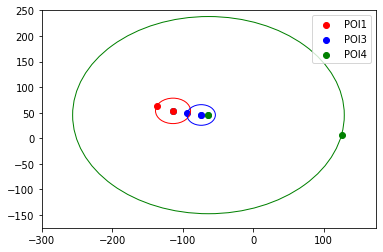

<Figure size 5400x4320 with 0 Axes>

In [9]:
# For each POI, draw a circle including all all of it's assigned requests.
# Each POI is located at the center of it's circle (differentiated by colour) with it's farthest request plotted on the perimeter.

fig, ax = plt.subplots()
figure(figsize=(15,12), dpi=360)

xs = poi['Longitude']
ys = poi[' Latitude']
ax.scatter(xs, ys)
# print(xs, ys)

maxCoords = pd.Series([poi1_maxDistCoords, poi3_maxDistCoords, poi4_maxDistCoords])
# print(maxCoords)

cir_1 = plt.Circle((xs[0], ys[0]), poi1_radius, color='r', fill=False)
cir_3 = plt.Circle((xs[2], ys[2]), poi3_radius, color='b', fill=False)
cir_4 = plt.Circle((xs[3], ys[3]), poi4_radius, color='g', fill=False)

ax.add_patch(cir_4)
ax.add_patch(cir_1)
ax.add_patch(cir_3)

ax.scatter(xs[0],ys[0], color='r', label='POI1')
ax.scatter(maxCoords[0][1], maxCoords[0][0], color='r')

ax.scatter(xs[2],ys[2], color='b', label='POI3')
ax.scatter(maxCoords[1][1], maxCoords[1][0], color='b')

ax.scatter(xs[3],ys[3], color='g', label='POI4')
ax.scatter(maxCoords[2][1], maxCoords[2][0], color='g')

ax.set_xlim(-300, 175)
ax.set_ylim(-175, 250)
ax.legend()
plt.show()

## 4. Data Science/Engineering Tracks

Please complete either 4a or 4b. Extra points will be awarded for completing both tasks.

### 4a. Model
1. To visualize the popularity of each POI, they need to be mapped to a scale that ranges from -10 to 10. Please provide a mathematical model to implement this, taking into consideration of extreme cases and outliers. Aim to be more sensitive around the average and provide as much visual differentiability as possible.
2. **Bonus**: Try to come up with some reasonable hypotheses regarding POIs, state all assumptions, testing steps and conclusions. Include this as a text file (with a name bonus) in your final submission. 

**Bonus has been completed. Please see bonus.txt in files for my solution. Thank you.**

In [10]:
# Map densities for each POI into a min/max range of [-1, 1] and multiply by 10
densities = np.array([poi1_density, poi3_density, poi4_density]).reshape(-1,1)
scaler = MinMaxScaler(feature_range=(-1,1))
transformed = scaler.fit_transform(densities).flatten() * 10
print('Scaled values for popularity of each POI: ', transformed)

Scaled values for popularity of each POI:  [  6.63417288  10.         -10.        ]


Text(0.5, 1.0, 'Popularity of POIs Mapped to [-10, 10] Range')

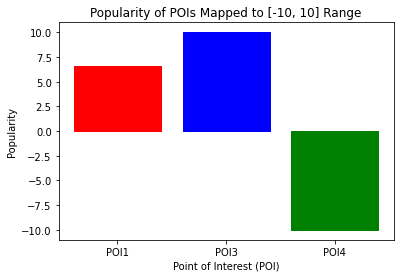

In [11]:
# Visualize new range
fig, ax = plt.subplots()
x = ['POI1', 'POI3', 'POI4']
bars = plt.bar(x, transformed)
bars[0].set_color('r')
bars[1].set_color('b')
bars[2].set_color('g')
ax.set_ylabel('Popularity')
ax.set_xlabel('Point of Interest (POI)')
ax.set_title('Popularity of POIs Mapped to [-10, 10] Range')